# CCPi CIL and SIRF

* CIL is an heterogeneous collection of software codes for Computed Tomography
* Beam Hardening
* CT iterative reconstruction algorithms in C++
* Segmentation
* Digital Volume correlation (for strain)
* Visualisation (3D Viewer)

## Optimisation

In [11]:
'''
GRAPPA reconstruction with an iterative algorithm from CIL: illustrates
the use of AcquisitionModel in CIL optimisation 

Usage:
  grappa_and_cil.py [--help | options]

Options:
  -f <file>, --file=<file>    raw data file
                              [default: simulated_MR_2D_cartesian_Grappa2.h5]
  -p <path>, --path=<path>    path to data files, defaults to data/examples/MR
                              subfolder of SIRF root folder
'''

## CCP PETMR Synergistic Image Reconstruction Framework (SIRF)
## Copyright 2015 - 2019 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2019 University College London.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.


import sirf
from sirf.Utilities import existing_filepath
from sirf.Utilities import error
from sirf.Utilities import show_3D_array
from sirf.Gadgetron import examples_data_path
from sirf.Gadgetron import AcquisitionData, ImageData
from sirf.Gadgetron import AcquisitionModel
from sirf.Gadgetron import AcquisitionDataProcessor
from sirf.Gadgetron import CartesianGRAPPAReconstructor
from sirf.Gadgetron import CoilSensitivityData


from ccpi.optimisation.functions import Norm2Sq
from ccpi.optimisation.functions import ZeroFunction
from ccpi.optimisation.algorithms import FISTA, CGLS, GradientDescent
from ccpi.plugins.regularisers import FGP_TV#, TGV, LLT_ROF, Diff4th
from ccpi.framework import DataContainer as cilDataContainer

import numpy
import time
%matplotlib notebook
import matplotlib.pyplot as plt




In [2]:
class cilPluginToSIRFFactory(object):
    '''Factory to create SIRF wrappers for CCPi CIL plugins'''
    @staticmethod
    def getInstance(thetype, **kwargs):
        '''Returns an instance of a CCPi CIL plugin wrapped to work on SIRF DataContainers'''
        obj = thetype(**kwargs)
        orig_prox = obj.prox
        obj.prox = cilPluginToSIRFFactory.prox(orig_prox, 
                                               obj.__class__.__name__)
        return obj
    @staticmethod
    def prox(method, classname):
        def wrapped(x, sigma):
            '''Wrapped method'''
            print("calling ", classname)
            if isinstance(x, sirf.Gadgetron.ImageData):
                # if the data is MR => complex we operate the regulariser
                # only on the real part
                X = x.as_array()
                out = method(cilDataContainer(X.real), sigma)
                X.real[:] = out.as_array()
                y = x.copy()
                y.fill(X)
            else:
                out = method(x, sigma)
                y = x.copy()
                y.fill(out.as_array())
            print("done")
                
            return y
        return wrapped
    
def PowerMethod(operator, iterations, x_init=None):
        '''Power method to calculate iteratively the Lipschitz constant'''
        
        # Initialise random
        if x_init is None:
            x0 = operator.domain_geometry().allocate(type(operator.domain_geometry()).RANDOM_INT)
        else:
            x0 = x_init.copy()
            
        x1 = operator.domain_geometry().allocate()
        y_tmp = operator.range_geometry().allocate()
        s = numpy.zeros(iterations)
        # Loop
        for it in numpy.arange(iterations):
            operator.direct(x0,out=y_tmp)
            operator.adjoint(y_tmp,out=x1)
            x1norm = x1.norm()
            s[it] = x1.dot(x0) / x0.squared_norm()
            x1.multiply((1.0/x1norm), out=x0)
        return numpy.sqrt(s[-1]), numpy.sqrt(s), x0

## Prepare the Data and AcquisitionModel

/home/sirfuser/devel/buildVM/sources/SIRF/data/examples/MR/simulated_MR_2D_cartesian_Grappa2.h5
---
 pre-processing acquisition data...
---
 reconstructing...
---
 sorting acquisition data...
---
 computing sensitivity maps...


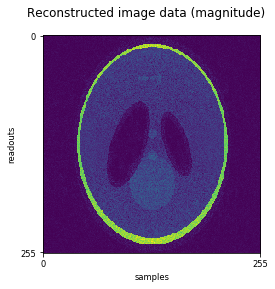

In [3]:
# process command-line options
data_file = 'simulated_MR_2D_cartesian_Grappa2.h5'
data_path = None

if data_path is None:
    data_path = examples_data_path('MR')
    

# locate the input data file
input_file = existing_filepath(data_path, data_file)
print (input_file)


# acquisition data will be read from an HDF file input_data
acq_data = AcquisitionData(input_file)

# pre-process acquisition data
print('---\n pre-processing acquisition data...')
# the following function runs a GadgetChain data processor
# preprocessed_data = preprocess_acquisition_data(acq_data)
gadget_chain = ['NoiseAdjustGadget', \
                'AsymmetricEchoAdjustROGadget', \
                'RemoveROOversamplingGadget']
ap = AcquisitionDataProcessor( gadget_chain )
ap.set_input( acq_data )
ap.process()
preprocessed_data = ap.get_output()


# perform reconstruction
recon = CartesianGRAPPAReconstructor()
recon.set_input( preprocessed_data )
recon.compute_gfactors( False )
print('---\n reconstructing...')
recon.process()
# for undersampled acquisition data GRAPPA computes Gfactor images
# in addition to reconstructed ones
image_data = recon.get_output()

image_array = image_data.as_array()
title = 'Reconstructed image data (magnitude)'
show_3D_array(abs(image_array), suptitle = title, label = 'slice', \
              xlabel = 'samples', ylabel = 'readouts', show = False)

# compute coil sensitivity maps
csms = CoilSensitivityData()
print('---\n sorting acquisition data...')
preprocessed_data.sort()
print('---\n computing sensitivity maps...')
csms.calculate( preprocessed_data )

In [4]:
# create acquisition model based on the acquisition parameters
# stored in preprocessed_data and image parameters stored in
# image_data
acq_model = AcquisitionModel( preprocessed_data, image_data )
acq_model.set_coil_sensitivity_maps( csms )

# use the acquisition model (forward projection) to simulate acquisition data
simulated_data = acq_model.forward( image_data )

# CIL/SIRF integration

Create the objective function as Norm2square
$$
c || A x - b ||^2
$$
where $c$ is a constant, $A$ is the linear operator and $b$ are the data.

You may need to close Figure 1 window to continue...


/home/sirfuser/devel/install/python/ccpi/optimisation/functions/Norm2Sq.py:54: UserWarning: Norm2Sq could not calculate Lipschitz Constant. AcquisitionModel instance has no attribute 'norm'
  self.__class__.__name__, ae))


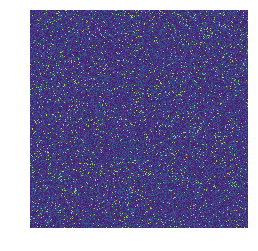

0

In [5]:
# create a Norm2square objective function
# c || Ax - b ||^2
norm2sq = Norm2Sq( A = acq_model , b = preprocessed_data , c = 1)
# create a random initialisation image by shuffling the real
# image data. 
x_init = image_data.copy()
x = x_init.as_array().flatten()
numpy.random.shuffle(x)
x = numpy.reshape(x, x_init.as_array().shape)
x_init.fill(x)
del x

show_3D_array(x_init.as_array().real)

The linear operator $A$, the AcquisitionModel, should satisfy this: 

$Ax_0\times y_0 = y_0 \times A^Tx_0$

In [6]:
# test if <Ax0,y0> = <y0, A^Tx0>
y0 = simulated_data.copy()
x = y0.as_array().flatten()
numpy.random.shuffle(x)
x = numpy.reshape(x, y0.as_array().shape)
y0.fill(x)
del x     
x0 = x_init
fx0 = acq_model.direct(x0)
by0 = acq_model.adjoint(y0)
a = fx0.dot(y0)
b = by0.dot(x0)
numpy.testing.assert_almost_equal(abs((a-b)/a), 0, decimal=4)

In [7]:
from ccpi.optimisation.operators import LinearOperator

lipschitz = LinearOperator.PowerMethod(acq_model, 10, x_init)[0]

norm2sq.L = lipschitz  
print ("Lipschitz " , norm2sq.L)

('Lipschitz ', 0.9952370101490726)


In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interactive_plot = False

# create a Gradient Descent algorithm which minimises norm2sq
gd = GradientDescent(x_init=x_init, 
           objective_function=norm2sq, rate=lipschitz/3.)

('GradientDescent', 'set_up called from creator')


In [ ]:
gd.max_iteration = 50
pixval = []
gadgval = image_data.as_array()[0][46][160]


if interactive_plot:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    im = fig.add_subplot(122)
    im.imshow(abs(x_init.as_array()[0]))
    fig.show()
    fig.canvas.draw()

    for i in gd:
        ax.clear()
        pixval.append( gd.get_output().as_array()[0][46][160])
        print ("\rIteration {} Loss: {} pix {}".format(gd.iteration, 
               gd.get_last_loss(), pixval[-1]/gadgval))
        ax.semilogy([val/gd.loss[0] for val in gd.loss])
        im.imshow(abs(gd.get_output().as_array()[0]))
        fig.canvas.draw()
else:
    gd.update_objective_interval = 1
    gd.run(50,verbose=True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogy([val/gd.loss[0] for val in gd.loss])
    im = fig.add_subplot(122)
    im.imshow(abs(gd.get_output().as_array()[0]))
    fig.show()
    

In [18]:
#show_3D_array(gd.get_output().as_array().real, suptitle='Gradient Descent (magnitude)')

#%%
# USE FISTA with Regularisation   
no_regulariser = ZeroFunction()
# create a regulariser with the Factory
regulariser = cilPluginToSIRFFactory.getInstance(FGP_TV, 
                                       lambdaReg=.1,
                                       iterationsTV=300,
                                       tolerance=1e-5,
                                       methodTV=0,
                                       nonnegativity=0,
                                       printing=0,
                                       device='cpu')
options = {'tol': 1e-4, 'iter': 10, 'memopt':False}

norm2sq.L = lipschitz*3.
# create a FISTA algorithm instance
fista = FISTA(x_init=x_init, f=norm2sq, g=regulariser, opt=options)

('FISTA', 'set_up called from creator')


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [ ]:
fista.max_iteration = 50
fpixval = []
#%%
# run FISTA


if interactive_plot:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    im = fig.add_subplot(122)
    im.imshow(abs(x_init.as_array()[0]))
    fig.show()
    fig.canvas.draw()
    for i,el in enumerate(fista):
        ax.clear()
        fpixval.append( fista.get_output().as_array()[0][46][160])
        if i%1 == 0:
            print ("\rFISTA Iteration {} Loss: {} pix {}".format(fista.iteration, 
               fista.get_last_loss(), fpixval[-1]/gadgval))
            ax.semilogy([val/fista.loss[0] for val in fista.loss])
            im.imshow(abs(fista.get_output().as_array()[0]))
            fig.canvas.draw()
#%%
else:
    fista.update_objective_interval = 1
    fista.run(20, verbose=True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogy([val/fista.loss[0] for val in fista.loss])
    im = fig.add_subplot(122)
    im.imshow(abs(x_init.as_array()[0]))
    fig.show()
    

In [ ]:
options = {'tol': 1e-4, 'iter': 20, 'memopt':False}
fista_noreg = FISTA(x_init=x_init, f=norm2sq, g=no_regulariser, opt=options)
fista_noreg.max_iteration = 20
fpixval = []
#%%
# run FISTA

In [ ]:
if interactive_plot:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    im = fig.add_subplot(122)
    im.imshow(abs(x_init.as_array()[0]))
    fig.show()
    fig.canvas.draw()

    for i,el in enumerate(fista_noreg):
        ax.clear()
        fpixval.append( fista_noreg.get_output().as_array()[0][46][160])
        if i%1 == 0:
            print ("\rFISTA Iteration {} Loss: {} pix {}".format(
                fista_noreg.iteration, 
                fista_noreg.get_last_loss(), 
                fpixval[-1]/gadgval))
            ax.semilogy([val/fista_noreg.loss[0] for val in fista_noreg.loss])
            im.imshow(abs(fista_noreg.get_output().as_array()[0]))
            fig.canvas.draw()
else:
    fista_noreg.run(20, verbose=True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogy([val/fista_noreg.loss[0] for val in fista_noreg.loss])
    im = fig.add_subplot(122)
    im.imshow(abs(fista_noreg.get_output().as_array()[0]))
    fig.show()
    

In [ ]:
# plot convergence
print (gd._iteration)
fig = plt.figure()
ax = plt.semilogy([gd.loss[i]/max(gd.loss) for i in range(20)], label='Gradient Descent')
#ax = plt.plot([el/max(fista_noreg.loss) for el in fista_noreg.loss], label='FISTA')
ax = plt.semilogy([el/max(fista.loss) for el in fista.loss], label='FISTA + FGP_TV')
plt.legend()
plt.show()

In [ ]:
#%%
# plot the results
fig = plt.figure()
#ax1 = plt.subplot(1,4,1)
#plt.imshow(abs(image_data.as_array()[0]), cmap='gray')
#plt.clim(0, 5)
#ax1.set_title('Initial Data')
#ax2 = plt.subplot(1,4,2)
ax2 = plt.subplot(1,2,1)
plt.imshow(abs(gd.get_output().as_array()[0]), cmap='gray')
plt.clim(0, 1.)
ax2.set_title('Gradient Descent')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
#ax2 = plt.subplot(1,4,3)
#ax2 = plt.subplot(1,2,1)
#plt.imshow(abs(fista_noreg.get_output().as_array()[0]), cmap='gray')
#plt.clim(0, 5)
#ax2.set_title('FISTA no reg')
#ax2 = plt.subplot(1,4,4)
ax2 = plt.subplot(1,2,2)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.imshow(abs(fista.get_output().as_array()[0]), cmap='gray')
plt.clim(0, 1.)
ax2.set_title('FISTA + FGP_TV')
plt.show()
#%%


In [ ]:
print (gadgval)

fista_noreg.max_iteration = 100
fista_noreg.update_objective_interval = 5
fista_noreg.run(10)

cgls = CGLS(x_init=x_init, operator=acq_model, data=preprocessed_data)


In [ ]:
cgls.max_iteration=50
cgls.run(12)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy([val/cgls.loss[0] for val in cgls.loss])
im = fig.add_subplot(122)
im.imshow(abs(cgls.get_output().as_array()[0]))
fig.show()

In [21]:
from ccpi.optimisation.functions import L2NormSquared
from ccpi.optimisation.algorithms import PDHG
from ccpi.optimisation.operators import Gradient

sigma = 1.
normK = lipschitz
# Primal & dual stepsizes
tau = 1 / (sigma * normK ** 2) - 1e-2

#g = Gradient(acq_model.domain_geometry())

pdhg = PDHG()
pdhg.set_up(f=L2NormSquared(b=preprocessed_data), g=ZeroFunction(), operator=acq_model, tau=tau, sigma=sigma)
pdhg.max_iteration = 50
pdhg.run(1)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0         50         0.000    2.02616e+04 -0.00000e+00-0.00000e+00j2.02616e+04+0.00000e+00j
        1         50         0.000    2.53361e+04 -1.80507e+03+5.47271e+03j2.71411e+04-5.47271e+03j


<IPython.core.display.Javascript object>


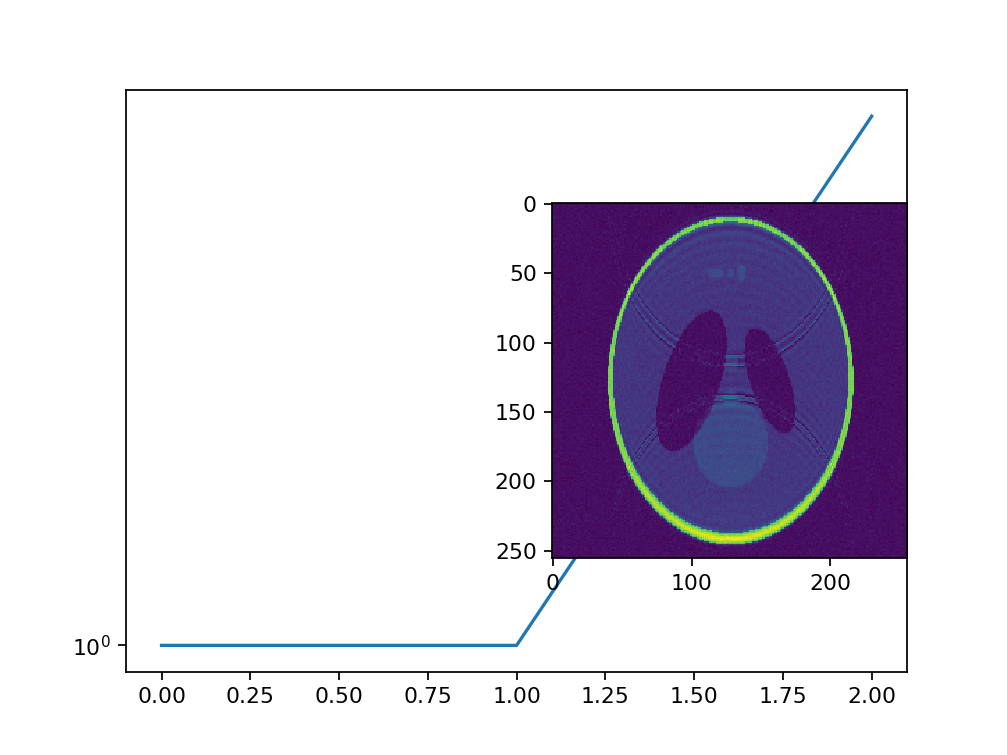

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy([val[0]/pdhg.loss[0][0] for val in pdhg.loss])
im = fig.add_subplot(122)
im.imshow(abs(pdhg.get_output().as_array()[0]))
fig.show()